In [3]:
# all the imports

import json
from Filters import Filters
from Data_load import data_load

from Model import Model

import matplotlib.pyplot as plt

from utils import *

import time

2024-11-12 09:26:36.731600: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 09:26:36.792151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 09:26:37.767948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Now we need to get the data using our class Data_Load

In [2]:
# Import the filtered images
data = data_load()
train_images, train_labels, test_images, test_labels = data.data_mnist()

60000


In [3]:
train_images.shape

(60000, 28, 28, 1)

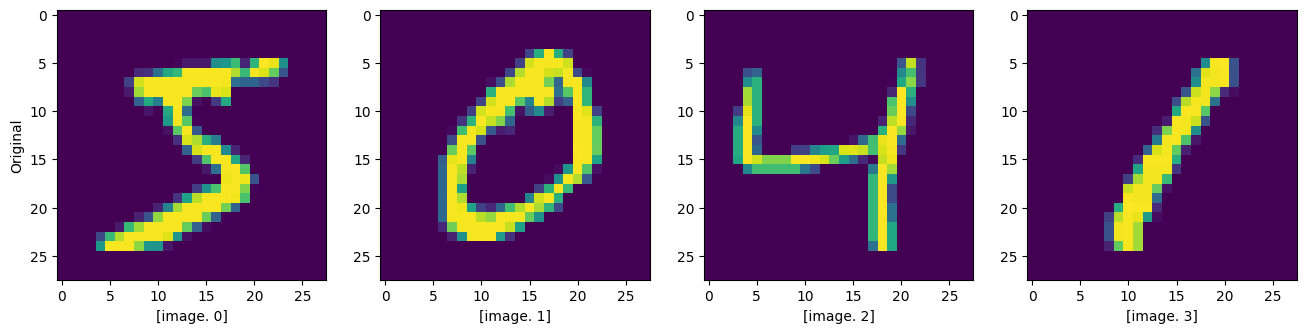

In [4]:
# Vizualise the image before filtering


# vizualise the filtered images:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot all output channels for quantum cnot find TensorRT
axes[0].set_ylabel("Original")
for c in range(4):
    axes[c].set_xlabel("[image. {}]".format(c))
    axes[c].imshow(train_images[c, :, :])

In [5]:
# select a few images for 
train_images = train_images[0:10, :, :]
test_images = test_images[0:5, :, :]

## building the quantum circuit

In [15]:
import pennylane as qml

dev = qml.device("default.qubit", wires=4)


def circuit( phi, meas_last, dev):
    n_qubits = len(phi)

    @qml.qnode(dev)
    def qnode():
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)

        # Filter from arxiv.org/abs/2308.14930
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 3])

        if meas_last is True:    # measure only the last qubit if meas_last is set to True
            return [qml.expval(qml.PauliZ(n_qubits-1))]
        else:
            return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    # print(qml.draw(qnode)())
    print(qml.draw_mpl(qnode)())
    return qnode()

(<Figure size 600x500 with 1 Axes>, <Axes: >)



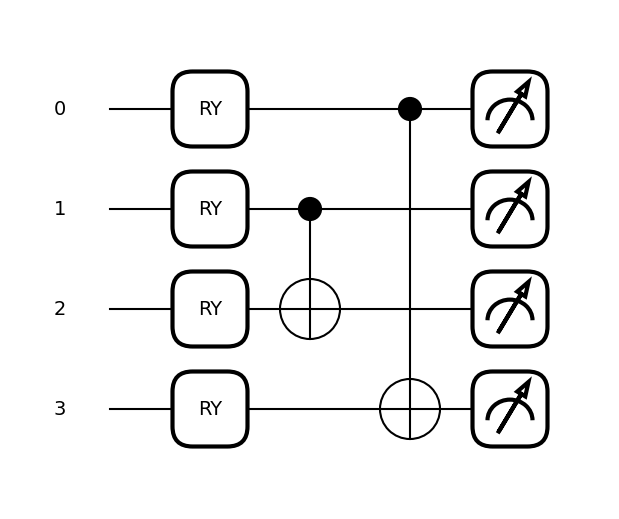

In [16]:
%matplotlib inline
print(qml.draw(circuit, show_all_wires=True)([0.1/np.pi,0.2/np.pi,0.3/np.pi,0.4/np.pi], False, dev))


## Now lets check which pixel of the images goes to each wire on the quantum circuit

In [8]:
def quantum_conv_filter(image, meas_last=False):
        image_height, image_width = image.shape[0], image.shape[1]
        
        stride = 2

        # measure only the last qubit (useful if all qubits are entangled)
        if meas_last is True:
            n_channels = 1
        else:
            n_channels = 4

        out = np.zeros((image_height // 2, image_width // 2, n_channels))
        dev = qml.device('default.qubit', wires=4)

        for j in range(0, image_height, stride):
            for k in range(0, image_width, stride):
                q_results = circuit([image[j, k, 0],
                                    image[j + 1, k, 0],
                                    image[j, k + 1, 0],
                                    image[j + 1, k + 1, 0]],
                                    meas_last,
                                    dev
                                    )
                print(f'({j}, {k}),   ({j+1}, {k }), ({j}, {k+1}),  ({j + 1}, {k + 1})')

                for c in range(len(q_results)):
                    out[j // stride, k // stride, c] = q_results[c]
        return out

In [9]:
train_images[1,:,:].shape

(28, 28, 1)

In [10]:
filtered = quantum_conv_filter(train_images[1,:,:], meas_last=False)

0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 0),   (1, 0), (0, 1),  (1, 1)
0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 2),   (1, 2), (0, 3),  (1, 3)
0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 4),   (1, 4), (0, 5),  (1, 5)
0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 6),   (1, 6), (0, 7),  (1, 7)
0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 8),   (1, 8), (0, 9),  (1, 9)
0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 10),   (1, 10), (0, 11),  (1, 11)
0: ──RY(0.00)────╭●─┤  <Z>
1: ──RY(0.00)─╭●─│──┤  <Z>
2: ──RY(0.00)─╰X─│──┤  <Z>
3: ──RY(0.00)────╰X─┤  <Z>
(0, 12),   (1, 12), (0, 13),  (1, 13

## Now lets plot the outcome of applying the 2 CNOT 2x2

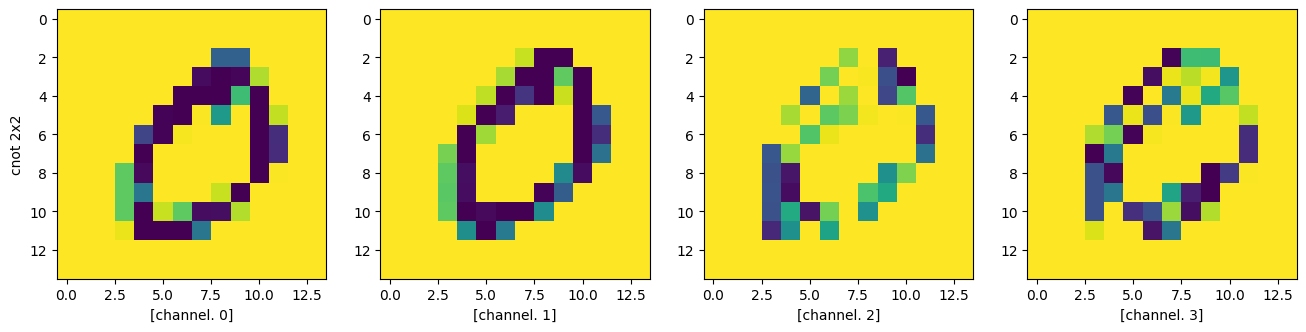

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot all output channels for quantum cnot find TensorRT
axes[0].set_ylabel("cnot 2x2")
for c in range(4):
    axes[c].set_xlabel("[channel. {}]".format(c))
    axes[c].imshow(filtered[:, :, c])

# those filtred images will be new images for the classical NN. 

Note that I changed the order of the pixels to match with the order in the paper. We had it wrong. Thanks Brian for finding this. 

To replicate figure 10 from arXiv:2308.11112, we do now need to modify def circuit to take the target and control for the cnot-gate as input, then we can do run to collect all the data required. 